# Install

In [10]:
!pip install sentencepiece

# Evn

In [11]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as KK

from tqdm.notebook import tqdm

In [12]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [13]:
!nvidia-smi

Tue Feb  9 09:36:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
!git clone https://github.com/e9t/nsmc
nsmc_dir = "/content/nsmc"
!git clone https://github.com/paul-hyun/nlp_data
data_dir = "/content/nlp_data"

fatal: destination path 'nsmc' already exists and is not an empty directory.
fatal: destination path 'nlp_data' already exists and is not an empty directory.


# Vocabulary & config

In [17]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [18]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [19]:
# config 생성
# d_model: model hidden dim
# n_head: multi head attention head number
# d_head: multi head attention head dim
# dropout: dropout rate
# d_ff: feed forward dim
# norm_eps: layernormal epsilon
# n_layer: layer number
# n_seq: sequence max number
# n_vocab: vocab count
# i_pad: vocab pad id
config = Config({"d_model": 256,
                 "n_head": 4,
                 "d_head": 64,
                 "dropout": 0.1,
                 "d_ff": 1024,
                 "norm_eps": 0.001,
                 "n_layer": 3,
                 "n_seq": 128,
                 "n_vocab": len(vocab),
                 "i_pad": vocab.pad_id()})
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 128,
 'n_vocab': 32007,
 'norm_eps': 0.001}

# 모델링

In [20]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad)
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_causal_mask(tokens, i_pad=0):
    """
    causal mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: causal and pad mask (causal or pad: 1, other: 0)
    """
    # 개수 조회
    n_seq = tf.shape(tokens)[1]
    # make ahead mask
    mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    # expand dim for bs
    mask = tf.expand_dims(mask, axis=0)
    # get pad_mask
    pad_mask = get_pad_mask(tokens, i_pad)
    # mask all ahead_mask or pad_mask
    mask = tf.maximum(mask, pad_mask)
    return mask


class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V)
        return attn_out


class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # build multihead Q, K, V
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [-1, tf.shape(Q)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [-1, tf.shape(K)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [-1, tf.shape(V)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        # build multihead mask
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out_m = self.attention((Q_m, K_m, V_m, attn_mask_m))  # (bs, n_head, Q_len, d_head)
        # transpose and reshape
        attn_out_t = tf.transpose(attn_out_m, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out_c = tf.reshape(attn_out_t, [-1, tf.shape(Q)[1], config.n_head * config.d_head])  # (bs, Q_len, d_model)
        # linear for output
        attn_out = self.W_O(attn_out_c) # (bs, Q_len, d_model)
        return attn_out


class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        # linear W_1 and W_2
        ff_val = self.W_1(inputs)
        ff_val = self.W_2(ff_val)
        return ff_val


class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name='encoder_layer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_hidden, self_mask tuple
        :return enc_out: EncoderLayer 실행 결과
        """
        enc_hidden, self_mask = inputs
        # self attention
        self_attn_val = self.self_attention((enc_hidden, enc_hidden, enc_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(enc_hidden + self.dropout(self_attn_val))
        
        # feed forward
        ffn_val = self.ffn(norm1_val)
        # add and layer normal
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, config, name='decoder_layer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ende_attn = MultiHeadAttention(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ffn = PositionWiseFeedForward(config)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: dec_hidden, enc_out, self_mask, ende_mask tuple
        :return dec_out: DecoderLayer 실행 결과
        """
        dec_hidden, enc_out, self_mask, ende_mask = inputs
        # self attention
        self_attn_val = self.self_attention((dec_hidden, dec_hidden, dec_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(dec_hidden + self.dropout(self_attn_val))

        # encoder and decoder attention
        ende_attn_val = self.ende_attn((norm1_val, enc_out, enc_out, ende_mask))
        # add and layer normal
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        # feed forward
        ffn_val = self.ffn(norm2_val)
        # add and layer normal
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out


class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name='weight_shared_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope('shared_embedding_weight'):
            self.shared_weights = self.add_weight(
                'weights',
                shape=[self.n_vocab, self.d_model],
                initializer=tf.keras.initializers.TruncatedNormal(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode='embedding'):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == 'embedding':
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == 'linear':
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f'mode {mode} is not valid.')
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        # lookup by gather
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        # muliply d_model ** 0.5
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        # matmul inputs, shared_weights (transpose_b=True)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        return outputs


class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name='position_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(config.n_seq, config.d_model)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        # make position (0...n_seq)
        position = tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True)
        position = tf.cast(position, tf.int32)
        # embedding lookup
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        # calculate angle
        exs = [2 * (i_ang // 2) / d_model for i_ang in range(d_model)]
        angles = [np.power(10000, ex) for ex in exs]
        # calculate position
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        # sin even number
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        # cos odd number
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)


class Transformer(tf.keras.Model):
    """
    Transformer Class
    """
    def __init__(self, config, name='transformer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        
        self.encoder_layers = [EncoderLayer(config, name=f'encoder_layer_{i}') for i in range(config.n_layer)]
        self.decoder_layers = [DecoderLayer(config, name=f'decoder_layer_{i}') for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_tokens, dec_tokens tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs
        # encoder self attention mask
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        # decoder self attention mask
        dec_self_mask = get_causal_mask(dec_tokens, self.i_pad)
        # encoder and decoder attention mask
        enc_dec_mask = get_pad_mask(enc_tokens, self.i_pad)

        # enc_tokens, dec_tokens embedding lookup
        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        # dropout for enc_embed
        enc_hidden = self.dropout(enc_embed)
        # call encoder layers
        for encoder_layer in self.encoder_layers:
            enc_hidden = encoder_layer((enc_hidden, enc_self_mask))
        
        # dropout for dec_embed
        dec_hidden = self.dropout(dec_embed)
        # call decoder layers
        for decoder_layer in self.decoder_layers:
            dec_hidden = decoder_layer((dec_hidden, enc_hidden, dec_self_mask, enc_dec_mask))

        # call weight shared embedding (model=linear)
        logits = self.embedding(dec_hidden, mode='linear')
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [21]:
def build_model(config):
    """
    Transformer Model
    :param config: configuration object
    """
    enc_inputs = tf.keras.layers.Input((None,))  # (bs, ?)
    dec_inputs = tf.keras.layers.Input((None,))  # (bs, ?)

    transformer = Transformer(config)
    logits = transformer((enc_inputs, dec_inputs))
    outputs = tf.keras.layers.Softmax(name="lm")(logits)

    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=outputs)
    return model

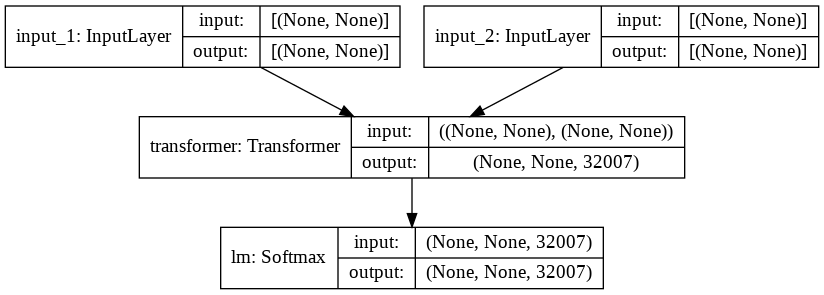

In [22]:
# 모델 생성
model = build_model(config)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Loss & Acc

In [23]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [24]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Scheduler

In [25]:
class InverseSquareRootSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    TransformerSchedule class
    """
    def __init__(self, d_model, warmup_steps=4000):
        """
        생성자
        :param d_model: 모델 hidden
        :param warmup_steps: warmup steps
        """
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        # calculate arg1 step_num ** -0.5
        arg1 = tf.math.rsqrt(step_num)
        # calculate arg2 step_num * warmup_steps ** -1.5
        arg2 = step_num * (self.warmup_steps**-1.5)
        # calcualte arg (min arg1 vs arg2)
        arg = tf.math.minimum(arg1, arg2)
        # calcualte lr (d_model ** -0.5 * arg)
        lr = tf.math.rsqrt(self.d_model) * arg
        return lr

# Sample Data Project

## Data


In [26]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [27]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [28]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [29]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [30]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,id,document,label
42986,9868530,공포 영화는 무슨...,0
25002,7745536,중심이 단단해야 이야기의 파급력도 커지는 법,0
104366,7951197,왜 공포스릴러에 코믹만 잔뜩들어간건데 근데 재미도없어,0
71235,6879284,인트로부터 결말까지하며 여운까지 완벽했던 애니메이션,1
118309,9441802,솔직히 시즌1이 전설이었지.,0
31809,8917151,참 할 말없게 만드네~~~ 몇십억대 집부터 이번에 캠핑카 까지~~ 한번 장볼때마다 ...,0
92264,9332061,옵대장과 나의 의리는 여기서부터 시작됬다,1
130960,9131754,그사람추기경을보러갔어요상영시작부터끝날때까지한순간도눈으뗄수가없고빠져들었습니다 우리나라...,1
113333,4673262,대박좋아요 너무잘만들었어요!,1
64882,9503750,영화가 점점 뒤로 갈수록 짜증나네~ㅋ,0


In [31]:
# 랜덤하게 10개만 확인
df_test = df_test.sample(10)
df_test

,id,document,label
4994,1852644,장난? ㅋ,0
5743,7871316,처음 오프닝 부분에 동네 주민 인터뷰.. 경찰청 사람들의 형사들도 이보단 자연스러웠...,0
19252,6794224,오글오글 발연기 진리콧물흘리는 유노윤호모습이 떠오르네,0
16263,8515669,이 명작이 왜 7점밖에 안될까요? 평점만 보고 안보려고 했다가 안봤다면 후회할 뻔한...,1
48841,5352737,올 봄 당신들의 가슴속에 각인 될 단 하나의 똥쓰레기 작품이 온다 에어리언 대 거미,1
29056,7999154,11111111,1
31231,3950845,아~~재미없어~~~,0
27711,9962436,이 영화보고 울었다...,1
46728,10047874,리메이크 없나요 ... 아~ 또 보고싶다 극장에서 ..,1
28939,4896895,독특한 소재를 참 심심하게 만들어내는 능력이 있는 감독,0


In [32]:
# text로 예측하기 위해 숫자를 문자로 변경
id_to_label = {0: '부정', 1: '긍정'}

def load_data(df, n_enc_seq, n_dec_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        label = row['label']
        # label을 문자로 변환
        label = id_to_label[label]
        document = row['document']
        print(label, document)
        # label tokenize
        lbl_tokens = vocab.encode_as_pieces(label)
        print(len(lbl_tokens), ':', lbl_tokens)
        # document tokenize
        doc_tokens = vocab.encode_as_pieces(document)
        print(len(doc_tokens), ':', doc_tokens)
        # token ids
        lbl_ids = vocab.encode_as_ids(label)[:dec_max]
        print(len(lbl_ids), ':', lbl_ids)
        doc_ids = vocab.encode_as_ids(document)[:n_enc_seq]
        print(len(doc_ids), ':', doc_ids)
        # encoder input
        enc_input = doc_ids + [0] * (n_enc_seq - len(doc_ids))
        print(len(enc_input), ':', enc_input)
        # decoder input
        dec_input = [vocab.bos_id()] + lbl_ids + [0] * (dec_max - len(lbl_ids))
        print(len(dec_input), ':', dec_input)
        # label
        label = lbl_ids + [vocab.eos_id()] + [0] * (dec_max - len(lbl_ids))
        print(len(label), ':', label)

        enc_inputs[index] = enc_input
        dec_inputs[index] = dec_input
        labels[index] = label
        index += 1
    return enc_inputs, dec_inputs, labels

In [33]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, 50, 4)
train_enc_inputs, train_dec_inputs, train_labels


부정 공포 영화는 무슨...
1 : ['▁부정']
6 : ['▁공포', '▁영화는', '▁무슨', '.', '.', '.']
1 : [2741]
6 : [3049, 4454, 13584, 7, 7, 7]
50 : [3049, 4454, 13584, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 : [2, 2741, 0, 0]
4 : [2741, 3, 0, 0]

부정 중심이 단단해야 이야기의 파급력도 커지는 법
1 : ['▁부정']
12 : ['▁중심이', '▁단단', '해야', '▁이야기', '의', '▁파', '급', '력', '도', '▁커', '지는', '▁법']
1 : [2741]
12 : [8326, 18268, 767, 1224, 9, 466, 442, 814, 32, 1690, 792, 924]
50 : [8326, 18268, 767, 1224, 9, 466, 442, 814, 32, 1690, 792, 924, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 : [2, 2741, 0, 0]
4 : [2741, 3, 0, 0]

부정 왜 공포스릴러에 코믹만 잔뜩들어간건데 근데 재미도없어
1 : ['▁부정']
20 : ['▁왜', '▁공포', '스', '릴', '러', '에', '▁코믹', '만', '▁잔', '뜩', '들어', '간', '건', '데', '▁근', '데', '▁재미', '도', '없', '어']
1 : [2741]
20 : [3020, 3049, 88, 1500, 428, 13, 14044, 63, 2207, 30300, 6248, 357, 754, 295, 167

(array([[ 3049,  4454, 13584,     7,     7,     7,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 8326, 18268,   767,  1224,     9,   466,   442,   814,    32,
          1690,   792,   924,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3020,  3049,    88,  1500,   428,    13, 14044,    63,  2207,
         30300,  6248,   357,   754,   295,  1671,   295, 16793,    32,
         12785,   108,     0,     0,     0,   

In [34]:
# test data 생성
test_enc_inputs, test_dec_inputs, test_labels = load_data(df_test, 50, 4)
test_enc_inputs, test_dec_inputs, test_labels


부정 장난? ㅋ
1 : ['▁부정']
4 : ['▁장난', '?', '▁', 'ᄏ']
1 : [2741]
4 : [17758, 1910, 11, 30938]
50 : [17758, 1910, 11, 30938, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 : [2, 2741, 0, 0]
4 : [2741, 3, 0, 0]

부정 처음 오프닝 부분에 동네 주민 인터뷰.. 경찰청 사람들의 형사들도 이보단 자연스러웠다.연기자고 엑스트라고 오그라드는 발연기에 소름이 돋는다. AV연기가 더 낫다 레알.. 솔직히 내가 해도 저거보단 낫겠다 싶다
1 : ['▁부정']
57 : ['▁처음', '▁오프닝', '▁부분에', '▁동네', '▁주민', '▁인터뷰', '.', '.', '▁경찰청', '▁사람들의', '▁형사', '들도', '▁이', '보', '단', '▁자연', '스러웠', '다', '.', '연기', '자', '고', '▁엑스트라', '고', '▁오', '그라드', '는', '▁발', '연기', '에', '▁소', '름', '이', '▁돋', '는', '다', '.', '▁AV', '연기', '가', '▁더', '▁낫', '다', '▁레알', '.', '.', '▁솔직', '히', '▁내가', '▁해도', '▁저', '거', '보', '단', '▁낫', '겠다', '▁싶다']
1 : [2741]
50 : [626, 11148, 5866, 16431, 4147, 9811, 7, 7, 18921, 4370, 5466, 2617, 30, 194, 338, 906, 28028, 49, 7, 18357, 70, 37, 28570, 37, 180, 21649, 10, 698, 18357, 13, 232, 1544, 17, 24952, 10, 49, 7, 16173, 183

(array([[17758,  1910,    11, 30938,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  626, 11148,  5866, 16431,  4147,  9811,     7,     7, 18921,
          4370,  5466,  2617,    30,   194,   338,   906, 28028,    49,
             7, 18357,    70,    37, 28570,    37,   180, 21649,    10,
           698, 18357,    13,   232,  1544,    17, 24952,    10,    49,
             7, 16173, 18357,    19,   152, 15027,    49,  5561,     7,
             7, 25433,   387,  7385,  4772],
        [  180,  2473,   170,  2473,   698, 18357,  9781, 15662,   546,
         10234,  1933,   222,   210,  1261,   156,   292,  1915,    17,
         17202,   354,     0,     0,     0,   

## 학습

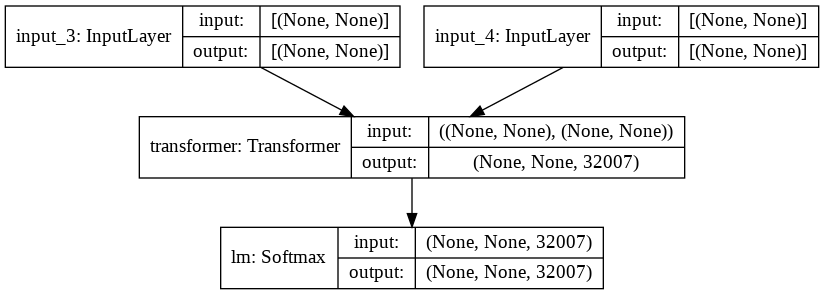

In [35]:
# 모델 생성
model = build_model(config)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [36]:
# learning_rate = InverseSquareRootSchedule(config.d_model, warmup_steps=1000)
# scheduler를 사용하면 학습이 불안정 함
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])

In [37]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'transformer.hdf5'),
                                                  monitor='val_lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'transformer.csv'))

In [38]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    validation_data=((test_enc_inputs, test_dec_inputs), test_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 5.5052 - lm_acc: 0.0000e+00 - val_loss: 2.6077 - val_lm_acc: 0.5000

Epoch 00001: val_lm_acc improved from -inf to 0.50000, saving model to /content/nsmc/transformer.hdf5
Epoch 2/100
1/1 [==============================] - 0s 111ms/step - loss: 2.6995 - lm_acc: 0.5000 - val_loss: 1.7812 - val_lm_acc: 0.5000

Epoch 00002: val_lm_acc did not improve from 0.50000
Epoch 3/100
1/1 [==============================] - 0s 99ms/step - loss: 1.7889 - lm_acc: 0.5000 - val_loss: 1.4322 - val_lm_acc: 0.5000

Epoch 00003: val_lm_acc did not improve from 0.50000
Epoch 4/100
1/1 [==============================] - 0s 121ms/step - loss: 1.4554 - lm_acc: 0.5000 - val_loss: 1.2469 - val_lm_acc: 0.5000

Epoch 00004: val_lm_acc did not improve from 0.50000
Epoch 5/100
1/1 [==============================] - 0s 111ms/step - loss: 1.2851 - lm_acc: 0.5000 - val_loss: 1.1018 - val_lm_acc: 0.5000

Epoch 00005: val_lm_acc did not improve from 0.

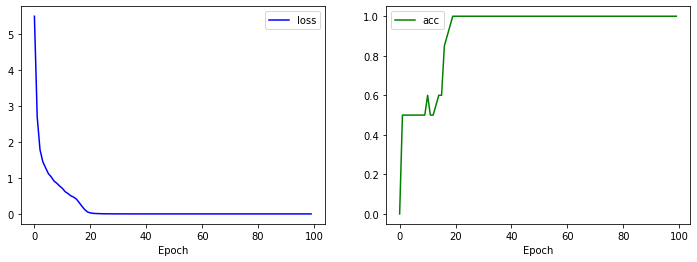

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [40]:
# 모델 생성
model = build_model(config)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'transformer.hdf5'))

In [42]:
# 예측 (전체를 처리하면 OOM 발생해서 분할 처리 함, 매 예측마다 32,0007개 확률값)
test_preds = []
n_batch = 128
for i in range(0, len(test_enc_inputs), n_batch):
    logits = model.predict((test_enc_inputs[i:i+n_batch], test_dec_inputs[i:i+n_batch]))
    pred_batch = list(np.argmax(logits, axis=-1)[:,0])  # 예측값 중에 첫번째 값만 확인하면 됨
    test_preds.extend(pred_batch)
len(test_preds)

10

In [43]:
# 오답 및 정답 확인
fail, success = 0, 0
for y_true, y_pred in zip(test_labels, test_preds):
    if int(y_true[0]) == int(y_pred):
        success += 1
    else:
        fail += 1
fail, success

(4, 6)

In [44]:
# 실제 정확 도
accuracy = success / (fail + success)
accuracy

0.6

In [45]:
def do_chat(vocab, model, n_enc, n_dec, string):
    """
    nsmc predict
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc]
    q_id += [0] * (n_enc - len(q_id))
    assert len(q_id) == n_enc

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec - len(a_id))
    assert len(a_id) == n_dec

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [46]:
while True:
    string = input('감정분류 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 50, 4, string)
    print(f'답변 > {predict_str}')

감정분류 문장 > 나는 너무 화가 난다.
답변 > 부정
감정분류 문장 > 나는 너무 화가 나지 않는다.
답변 > 부정


KeyboardInterrupt: ignored

# All Data Project

## Data


In [47]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [48]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [49]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [50]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [51]:
# text로 예측하기 위해 숫자를 문자로 변경
id_to_label = {0: '부정', 1: '긍정'}

def load_data(df, n_enc_seq, n_dec_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        # label을 문자로 변환
        label = id_to_label[label]
        document = row['document']
        # print(label, document)
        # label tokenize
        lbl_tokens = vocab.encode_as_pieces(label)
        # print(len(lbl_tokens), ':', lbl_tokens)
        # document tokenize
        doc_tokens = vocab.encode_as_pieces(document)
        # print(len(doc_tokens), ':', doc_tokens)
        # token ids
        lbl_ids = vocab.encode_as_ids(label)[:dec_max]
        # print(len(lbl_ids), ':', lbl_ids)
        doc_ids = vocab.encode_as_ids(document)[:n_enc_seq]
        # print(len(doc_ids), ':', doc_ids)
        # encoder input
        enc_input = doc_ids + [0] * (n_enc_seq - len(doc_ids))
        # print(len(enc_input), ':', enc_input)
        # decoder input
        dec_input = [vocab.bos_id()] + lbl_ids + [0] * (dec_max - len(lbl_ids))
        # print(len(dec_input), ':', dec_input)
        # label
        label = lbl_ids + [vocab.eos_id()] + [0] * (dec_max - len(lbl_ids))
        # print(len(label), ':', label)

        enc_inputs[index] = enc_input
        dec_inputs[index] = dec_input
        labels[index] = label
        index += 1
    return enc_inputs, dec_inputs, labels

In [52]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, 50, 4)
train_enc_inputs, train_dec_inputs, train_labels

(array([[  187, 15807,     7, ...,     0,     0,     0],
        [15969,     7,     7, ...,     0,     0,     0],
        [ 2379,   349,     1, ...,     0,     0,     0],
        ...,
        [   30,   139, 20601, ...,     0,     0,     0],
        [15425,  6969, 27152, ...,     0,     0,     0],
        [  243,   348,  1053, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2741,     0,     0],
        [    2, 26711,     0,     0],
        [    2,  2741,     0,     0],
        ...,
        [    2,  2741,     0,     0],
        [    2, 26711,     0,     0],
        [    2,  2741,     0,     0]], dtype=int32),
 array([[ 2741,     3,     0,     0],
        [26711,     3,     0,     0],
        [ 2741,     3,     0,     0],
        ...,
        [ 2741,     3,     0,     0],
        [26711,     3,     0,     0],
        [ 2741,     3,     0,     0]], dtype=int32))

In [53]:
# test data 생성
test_enc_inputs, test_dec_inputs, test_labels = load_data(df_test, 50, 4)
test_enc_inputs, test_dec_inputs, test_labels

(array([[ 5401,    11, 30938, ...,     0,     0,     0],
        [  606,   498,   835, ...,     0,     0,     0],
        [20601,   181,    30, ...,     0,     0,     0],
        ...,
        [ 2022,    32, 22514, ...,     0,     0,     0],
        [ 3790, 27925,    10, ...,     0,     0,     0],
        [ 4366,    10,   363, ...,     0,     0,     0]], dtype=int32),
 array([[    2, 26711,     0,     0],
        [    2,  2741,     0,     0],
        [    2,  2741,     0,     0],
        ...,
        [    2,  2741,     0,     0],
        [    2,  2741,     0,     0],
        [    2,  2741,     0,     0]], dtype=int32),
 array([[26711,     3,     0,     0],
        [ 2741,     3,     0,     0],
        [ 2741,     3,     0,     0],
        ...,
        [ 2741,     3,     0,     0],
        [ 2741,     3,     0,     0],
        [ 2741,     3,     0,     0]], dtype=int32))

## 학습

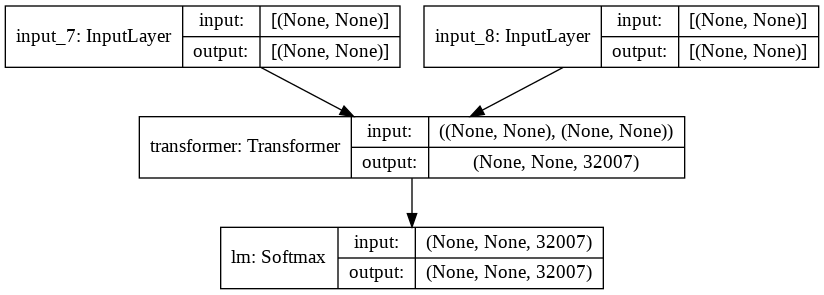

In [54]:
# 모델 생성
model = build_model(config)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [55]:
# learning_rate = InverseSquareRootSchedule(config.d_model, warmup_steps=1000)
# scheduler를 사용하면 학습이 불안정 함
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])

In [56]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_lm_acc', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'transformer.hdf5'),
                                                  monitor='val_lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'transformer.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    validation_data=((test_enc_inputs, test_dec_inputs), test_labels),
                    epochs=10,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

# 두 단어를 예측하는 것입 ['부정', 'EOS'] 또는 ['긍정', 'EOS']
# 별도로 평가를 진행 해야 함

Epoch 1/10
586/586 [==============================] - 181s 292ms/step - loss: 0.3025 - lm_acc: 0.7623 - val_loss: 0.1002 - val_lm_acc: 0.9077

Epoch 00001: val_lm_acc improved from -inf to 0.90767, saving model to /content/nsmc/transformer.hdf5
Epoch 2/10
586/586 [==============================] - 169s 288ms/step - loss: 0.0898 - lm_acc: 0.9233 - val_loss: 0.0953 - val_lm_acc: 0.9148

Epoch 00002: val_lm_acc improved from 0.90767 to 0.91485, saving model to /content/nsmc/transformer.hdf5
Epoch 3/10
 86/586 [===>..........................] - ETA: 2:02 - loss: 0.0766 - lm_acc: 0.9370

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(config)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'transformer.hdf5'))

In [ ]:
# 예측 (전체를 처리하면 OOM 발생해서 분할 처리 함, 매 예측마다 32,0007개 확률값)
test_preds = []
n_batch = 128
for i in range(0, len(test_enc_inputs), n_batch):
    logits = model.predict((test_enc_inputs[i:i+n_batch], test_dec_inputs[i:i+n_batch]))
    pred_batch = list(np.argmax(logits, axis=-1)[:,0])  # 예측값 중에 첫번
    째 값만 확인하면 됨
    test_preds.extend(pred_batch)
len(test_preds)

In [ ]:
# 오답 및 정답 확인
fail, success = 0, 0
for y_true, y_pred in zip(test_labels, test_preds):
    if int(y_true[0]) == int(y_pred):
        success += 1
    else:
        fail += 1
fail, success

In [ ]:
# 실제 정확 도
accuracy = success / (fail + success)
accuracy

In [ ]:
def do_chat(vocab, model, n_enc, n_dec, string):
    """
    nsmc predict
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc]
    q_id += [0] * (n_enc - len(q_id))
    assert len(q_id) == n_enc

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec - len(a_id))
    assert len(a_id) == n_dec

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
while True:
    string = input('감정분류 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 50, 4, string)
    print(f'답변 > {predict_str}')